# Spatial correlation matrix

In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
from pathlib import Path
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
data_path = Path.cwd().parent/"data"
plot_dir =  Path.cwd().parent/"plots"

In [3]:
cell_df = pd.read_parquet(data_path/"cellular_dataframe.parquet")

In [4]:
cell_df.columns

Index(['device', 'ping_ms', 'datarate', 'jitter', 'ts_gps', 'Latitude',
       'Longitude', 'Altitude', 'speed_kmh', 'COG', 'precipIntensity',
       'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint',
       'humidity', 'pressure', 'windSpeed', 'cloudCover', 'uvIndex',
       'visibility', 'Traffic Jam Factor', 'Traffic Street Name',
       'Traffic Distance', 'Pos in Ref Round', 'measurement', 'area',
       'PCell_RSRP_1', 'PCell_RSRP_2', 'PCell_RSRP_max', 'PCell_RSRQ_1',
       'PCell_RSRQ_2', 'PCell_RSRQ_max', 'PCell_RSSI_1', 'PCell_RSSI_2',
       'PCell_RSSI_max', 'PCell_SNR_1', 'PCell_SNR_2', 'PCell_E-ARFCN',
       'PCell_Downlink_Num_RBs', 'PCell_Downlink_TB_Size',
       'PCell_Uplink_Num_RBs', 'PCell_Uplink_TB_Size',
       'PCell_Uplink_Tx_Power_(dBm)', 'PCell_Cell_ID',
       'PCell_Downlink_frequency', 'PCell_Uplink_frequency',
       'PCell_Downlink_bandwidth_MHz', 'PCell_Uplink_bandwidth_MHz',
       'PCell_Cell_Identity', 'PCell_TAC', 'PCell_Band_In

## Add relevant data fields

In [5]:
# Unlike other PHY params, Max SNR is not available directly from Mobile Insight
cell_df['PCell_SNR_max'] = cell_df[['PCell_SNR_1', 'PCell_SNR_2']].max(axis=1)
cell_df['SCell_SNR_max'] = cell_df[['SCell_SNR_1', 'SCell_SNR_2']].max(axis=1)

# Set QoS parameter according to scenario
cell_df["datarate_UL"] = cell_df['datarate'].where(cell_df['scenario'] == 'A3U')
cell_df["datarate_DL"] = cell_df['datarate'].where(cell_df['scenario'] == 'A3D')
cell_df["delay_ms"] = cell_df['ping_ms'].where((cell_df['scenario'] == 'A2D')|(cell_df['scenario'] == 'A2U'))

cell_df["round_distance"] = np.round(cell_df["Pos in Ref Round"]) # Round for grouping

## Select relevant features, group and resample

In [6]:
feature_cols = ["device", "operator", "measurement",
                "round_distance", "datarate_UL", "datarate_DL", "delay_ms",
                'PCell_RSRP_max', 'PCell_RSRQ_max', 'PCell_RSSI_max', 'PCell_SNR_max']
corr_query = "drive_mode=='platoon' & (device=='pc3'|device=='pc4')"
cell_selection = cell_df.query(corr_query)[feature_cols]
cell_selection

,device,operator,measurement,round_distance,datarate_UL,datarate_DL,delay_ms,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max
timestamp,,,,,,,,,,,
2021-06-22 09:49:00+02:00,pc4,1,0,NaN,NaN,NaN,NaN,-83.476250,-14.573125,-50.520625,23.591
2021-06-22 09:49:00+02:00,pc3,2,0,NaN,NaN,NaN,NaN,-98.238125,-12.180625,-64.371875,10.306
2021-06-22 09:49:01+02:00,pc3,2,0,NaN,NaN,NaN,NaN,-97.295625,-12.177500,-63.360625,11.087
2021-06-22 09:49:01+02:00,pc4,1,0,NaN,NaN,NaN,NaN,-82.814375,-14.741250,-49.155625,23.814
2021-06-22 09:49:02+02:00,pc3,2,0,NaN,NaN,NaN,NaN,-98.058750,-12.145625,-64.093750,10.650
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23 17:06:57+02:00,pc4,1,10,359.0,NaN,NaN,25.56,-77.416250,-5.426875,-53.784375,15.224
2021-06-23 17:06:58+02:00,pc3,2,10,338.0,NaN,NaN,38.90,-104.820625,-9.124375,-77.008125,3.777
2021-06-23 17:06:58+02:00,pc4,1,10,370.0,NaN,NaN,27.88,-77.951875,-5.923125,-52.055625,16.172


## Cross-correlation

In [7]:
feature_cols = ["device", "operator", "measurement",
                "round_distance", "datarate_UL", "datarate_DL", "delay_ms",
                'PCell_RSRP_max', 'PCell_RSRQ_max', 'PCell_RSSI_max', 'PCell_SNR_max']
col_rename = {"datarate_UL": "Datarate\n(UL)", "datarate_DL": "Datarate\n(DL)",
              "delay_ms": "Delay",
              'PCell_RSRP_max': 'RSRP', 'PCell_RSRQ_max': 'RSRQ',
              'PCell_RSSI_max': 'RSSI', 'PCell_SNR_max': 'SNR'}
corr_query = "drive_mode=='platoon' & (device=='pc2'|device=='pc1')"
cell_selection = cell_df.query(corr_query)[feature_cols]
cell_selection

,device,operator,measurement,round_distance,datarate_UL,datarate_DL,delay_ms,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max
timestamp,,,,,,,,,,,
2021-06-22 09:49:00+02:00,pc1,1,0,NaN,NaN,NaN,NaN,-77.072500,-14.925000,-43.538750,21.351
2021-06-22 09:49:00+02:00,pc2,2,0,NaN,NaN,NaN,NaN,-99.379375,-19.018125,-88.133750,9.248
2021-06-22 09:49:01+02:00,pc2,2,0,NaN,NaN,NaN,NaN,-99.186250,-18.898125,-88.011875,9.444
2021-06-22 09:49:01+02:00,pc1,1,0,NaN,NaN,NaN,NaN,-78.630000,-14.986250,-44.452500,20.919
2021-06-22 09:49:02+02:00,pc1,1,0,NaN,NaN,NaN,NaN,-78.085000,-15.285000,-44.050625,20.355
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23 17:06:57+02:00,pc2,2,10,349.0,NaN,NaN,24.10,-66.651250,-6.313125,-69.340625,20.638
2021-06-23 17:06:58+02:00,pc1,1,10,317.0,NaN,NaN,46.45,-83.916250,-5.690000,-61.565000,10.768
2021-06-23 17:06:58+02:00,pc2,2,10,349.0,NaN,NaN,21.20,-67.316250,-6.630625,-69.320000,19.163


In [8]:
index_vars = ['measurement','round_distance']
cell_res_distance = cell_selection.groupby(['operator']+index_vars).mean(numeric_only=True).sort_index()
cell_res_distance.rename(columns=col_rename, inplace=True)
cell_res_distance

Datarate\n(UL)  Datarate\n(DL)  Delay  \
operator measurement round_distance                                          
1        0           0.0                        NaN     102000000.0    NaN   
                     6.0                        NaN     113000000.0    NaN   
                     17.0                       NaN     134000000.0    NaN   
                     29.0                       NaN     121000000.0    NaN   
                     40.0                       NaN     138000000.0    NaN   
...                                             ...             ...    ...   
2        10          17295.0                    NaN             NaN  25.00   
                     17301.0                    NaN             NaN  26.10   
                     17307.0                    NaN             NaN  19.90   
                     17313.0                    NaN             NaN  28.80   
                     17319.0                    NaN             NaN  22.05   

                                           RSRP      RSRQ       RSSI     SNR  
operator measurement round_distance                                           
1        0           0.0             -77.360000 -9.308125 -47.979375  19.759  
                     6.0             -75.998750 -9.368750 -46.586250  18.916  
                     17.0            -75.846875 -9.213125 -46.506250  18.288  
                     29.0            -76.516250 -9.191250 -47.208125  15.650  
                     40.0            -71.810000 -9.147500 -42.465000  17.421  
...                                         ...       ...        ...     ...  
2        10          17295.0        -103.181250 -7.634375 -95.078750  11.619  
                     17301.0        -106.482500 -7.568750 -94.980000  10.179  
                     17307.0        -103.062500 -7.888125 -95.044375  11.242  
                     17313.0        -105.351250 -7.350625 -94.879375  11.303  
                     17319.0        -104.091563 -7.595313 -94.932187  10.776  

[39397 rows x 7 columns]

In [9]:
op1, op2 = [cell_res_distance.query(f"operator == {op}") for op in (1,2)]
op1, op2 = [op.reset_index().drop(columns=['operator']).set_index(index_vars)
            for op in (op1, op2)]
op_concat = pd.merge(op1, op2, on=index_vars, how="outer", suffixes=("1","2")).sort_index()

In [10]:
n_feat = len(op_concat.columns)//2

op_xcorr = op_concat.corr()#.iloc[n_feat:,:n_feat]
op_xcorr

,Datarate\n(UL)1,Datarate\n(DL)1,Delay1,RSRP1,RSRQ1,RSSI1,SNR1,Datarate\n(UL)2,Datarate\n(DL)2,Delay2,RSRP2,RSRQ2,RSSI2,SNR2
Datarate\n(UL)1,1.000000,NaN,NaN,0.385781,0.140215,0.422679,0.127290,0.024266,NaN,NaN,0.087119,0.013937,0.161238,0.032427
Datarate\n(DL)1,NaN,1.000000,NaN,0.535719,0.273898,0.523151,0.587852,NaN,0.124197,0.006983,-0.034570,0.002639,0.019459,-0.026275
Delay1,NaN,NaN,1.000000,-0.022513,-0.060307,-0.007660,-0.044186,NaN,0.026950,-0.011813,-0.010067,0.013114,-0.035130,0.015094
RSRP1,0.385781,0.535719,-0.022513,1.000000,0.501001,0.927211,0.723017,0.112956,0.217175,0.062786,0.194755,0.048337,0.198014,0.116839
RSRQ1,0.140215,0.273898,-0.060307,0.501001,1.000000,0.217982,0.650502,0.077547,0.208939,0.113499,0.067244,0.074989,0.086312,0.098758
RSSI1,0.422679,0.523151,-0.007660,0.927211,0.217982,1.000000,0.595172,0.094400,0.191725,0.023393,0.200982,0.024457,0.200497,0.106770
SNR1,0.127290,0.587852,-0.044186,0.723017,0.650502,0.595172,1.000000,0.041881,0.106981,0.078761,0.086766,0.087729,0.077625,0.120275
Datarate\n(UL)2,0.024266,NaN,NaN,0.112956,0.077547,0.094400,0.041881,1.000000,NaN,NaN,0.580061,0.413698,0.499046,0.441201
Datarate\n(DL)2,NaN,0.124197,0.026950,0.217175,0.208939,0.191725,0.106981,NaN,1.000000,NaN,0.668143,0.228195,0.694101,0.685821
Delay2,NaN,0.006983,-0.011813,0.062786,0.113499,0.023393,0.078761,NaN,NaN,1.000000,-0.064544,-0.021518,-0.025986,-0.039243


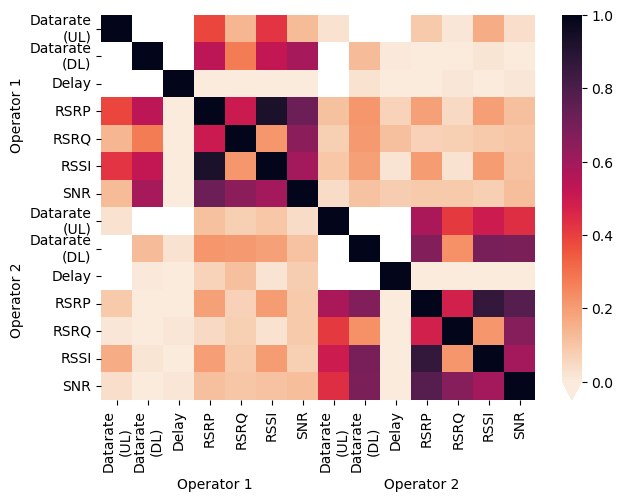

In [11]:
sns.heatmap(op_xcorr.rename(lambda x: x[:-1]).rename(columns=lambda x: x[:-1]),
            cmap="rocket_r", vmin=0, vmax=1, cbar_kws={"extend": "min"})

plt.xlabel("Operator 1"+(" "*30)+"Operator 2")
plt.ylabel("Operator 2"+(" "*25)+"Operator 1")
#plt.title("Correlation for 2 devices, 2 operators, aligned positions")
plt.gcf().set_size_inches(7, 5)
plt.savefig(plot_dir/"correlation_2operators.pdf", bbox_inches='tight')